# Building Fault Classification using Scikit-Learn


## **1. Install required dependencies**


In [4]:
import pandas as pd
import random
import numpy as np
import openpyxl
from matplotlib import pyplot as plt
import scikitplot as skplt
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, \
    RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus


## **2. Load and Process the Data**

In [5]:
SEED = 123456
np.random.seed(SEED)
random.seed(SEED)

In [6]:
def load_and_process(filename):
    cwd = os.getcwd()
    df = pd.read_csv(f"{cwd}/Data/{filename}.csv", delimiter=',')
    print(f"The initial df has the shape {df.shape}")
    # Remove NaN from df
    if df.isnull().values.any():
        df = df.dropna()
    # Remove error values
    if '#VALUE!' in df.values:
        for column in df.columns:
            for x in df.index:
                if df.loc[x, column] == '#VALUE!':
                    df.drop(x, inplace = True)
    print(f"The new df without NaN/wrong values entries has the shape {df.shape}")
    # Remove datetime and labels 
    X_raw = df[df.columns[1:-1]]
    # Labels
    y_raw = df.iloc[:,-1]
    return df, X_raw, y_raw

def split_and_scale(X_raw, y_raw):
    X_train, X_test, y_train, y_test = train_test_split(
    X_raw,
    y_raw,
    test_size=0.25,
    random_state = SEED
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test
    

## **3. Train a Logistic Regression, Decision Tree Model or MLP Classifier from Labels**

In [7]:
def train_classifier(algorithm, X_train, y_train):
    if algorithm == 'logistic_regression':
        clf = LogisticRegression(max_iter = 500)
    elif algorithm == 'decision_tree':
        clf = DecisionTreeClassifier(max_depth=6)
    elif algorithm == 'mlp':
        clf = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=0)
    clf.fit(X_train, y_train)
    return clf

def test_accuracy(clf, X_test, y_test, X_train, y_train):
    acc_og_test = clf.score(X_test, y_test)
    print(f"Accuracy on test dataset: {acc_og_test}")
    acc_og_train = clf.score(X_train, y_train)
    print(f"Accuracy train dataset: {acc_og_train}")

def plot_test_results(clf, X_test, y_test):
    y_pred_test = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    y_pred_prob = clf.predict_proba(X_test)
    y_pred_prob = np.array([t[0] for t in y_pred_prob])
    fig, ax = plt.subplots()
    ax.plot(y_pred_prob)
    ax.set_title('prediction probability of first 2000 entries of test dataset')
    fig.set_size_inches(18.5, 6)
    plt.xlim([0, 2000])

def coefficients_intercept(df, clf):

    print(clf.coef_, clf.intercept_)
    print(df.columns[1:-1])
    return clf.coef_, clf.intercept_

def plot_decision_tree(clf, df, filename):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = df.columns[1:-1],class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(f'{filename}_decision_tree.png')
    Image(graph.create_png())

def plot_rate_precision(clf, X_test, y_test):
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

## **3. MZVAV-1 Results**

#### Load and if needed, clean the data

In [85]:
filename = 'MZVAV-1'
df, X_raw, y_raw = load_and_process(filename)
df

The initial df has the shape (272160, 18)
The new df without NaN/wrong values entries has the shape (272160, 18)


,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
0,1/30/2017 0:00,68.00,55.04,32.00,68.00,75.20,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
1,1/30/2017 0:01,67.99,55.04,32.00,66.71,75.20,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
2,1/30/2017 0:02,67.99,55.04,-5.93,66.71,74.45,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
3,1/30/2017 0:03,67.99,55.04,-5.88,66.71,74.04,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
4,1/30/2017 0:04,67.99,55.04,-5.83,66.71,73.56,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272155,12/17/2017 23:55,55.04,55.04,17.89,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272156,12/17/2017 23:56,55.04,55.04,17.87,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272157,12/17/2017 23:57,55.04,55.04,17.85,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272158,12/17/2017 23:58,55.04,55.04,17.83,62.52,62.52,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1


In [86]:
X_train, X_test, y_train, y_test = split_and_scale(X_raw, y_raw)

#### Logistic Regression

Test accuracy of logistic regression on test dataset: 0.8553057025279247
Test accuracy of logistic regression on train dataset: 0.8577552420145013
[[ 4.88993108e-02  3.79609133e-14 -2.70367548e-02  1.63015034e-02
   1.52639475e-02 -8.05178619e-02 -8.05178619e-02  1.09937598e-01
   1.09937598e-01  3.67786279e-02  2.29587053e-02 -4.14950815e-02
   6.43495577e-04 -1.23570681e-17 -9.39648369e-02  1.20146961e-02]] [1.79836437]
Index(['AHU: Supply Air Temperature', 'AHU: Supply Air Temperature Set Point',
       'AHU: Outdoor Air Temperature', 'AHU: Mixed Air Temperature',
       'AHU: Return Air Temperature', 'AHU: Supply Air Fan Status',
       'AHU: Return Air Fan Status',
       'AHU: Supply Air Fan Speed Control Signal',
       'AHU: Return Air Fan Speed Control Signal',
       'AHU: Outdoor Air Damper Control Signal  ',
       'AHU: Return Air Damper Control Signal',
       'AHU: Cooling Coil Valve Control Signal',
       'AHU: Heating Coil Valve Control Signal',
       'AHU: Supply Ai

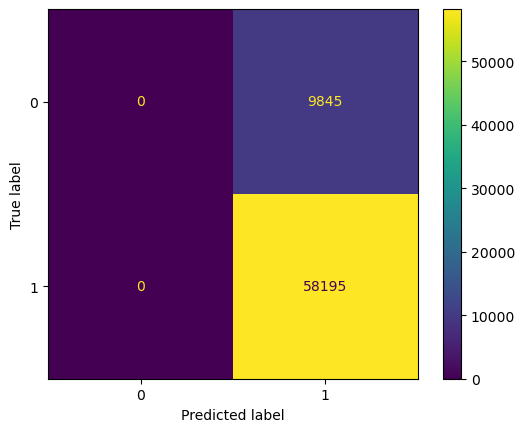

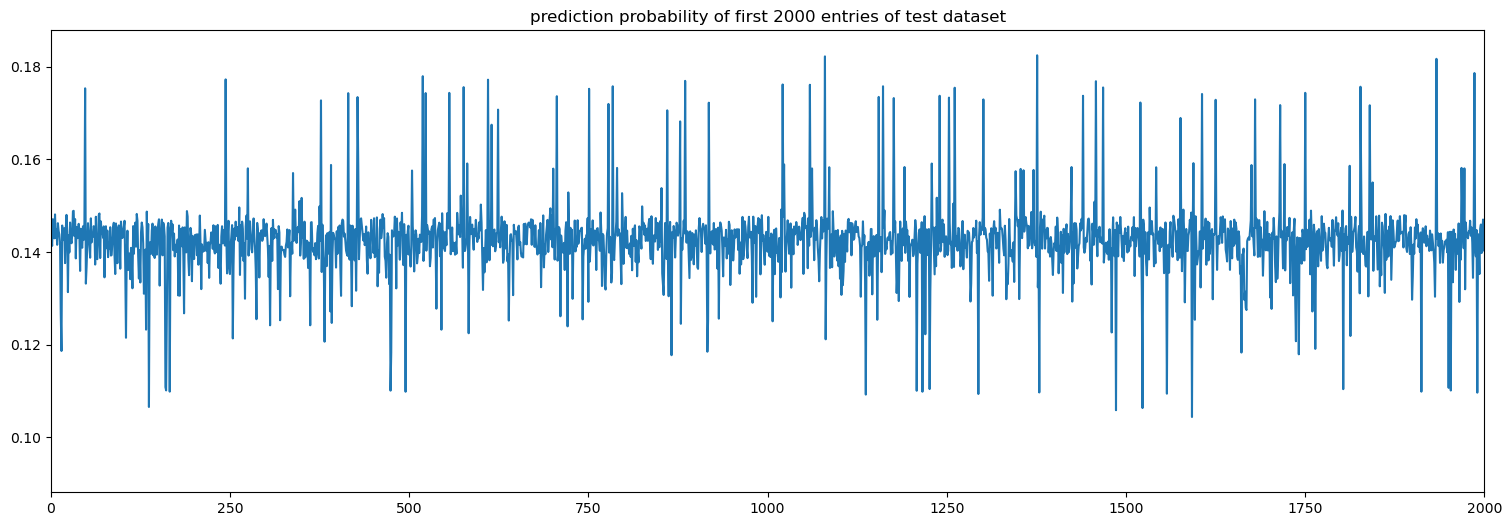

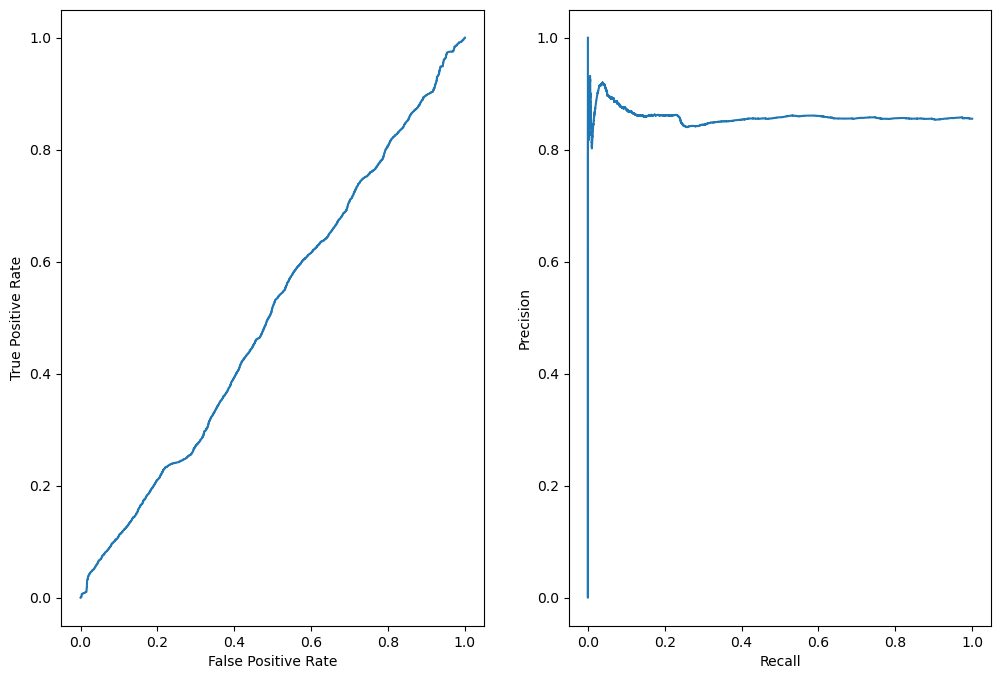

In [87]:
clf = train_classifier('logistic_regression', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
coeff, intercept = coefficients_intercept(df, clf)
plot_rate_precision(clf, X_test, y_test)

#### Decision Tree

Test accuracy of logistic regression on test dataset: 0.8590388007054673
Test accuracy of logistic regression on train dataset: 0.8611943954536547


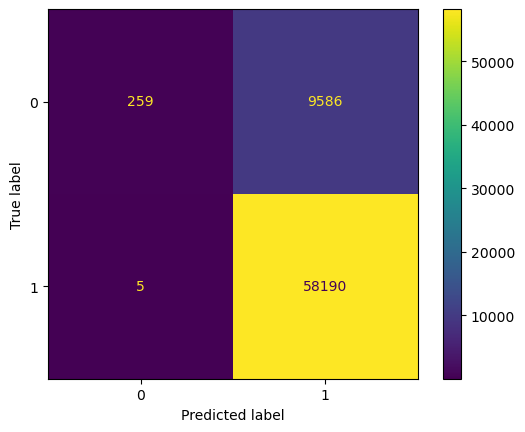

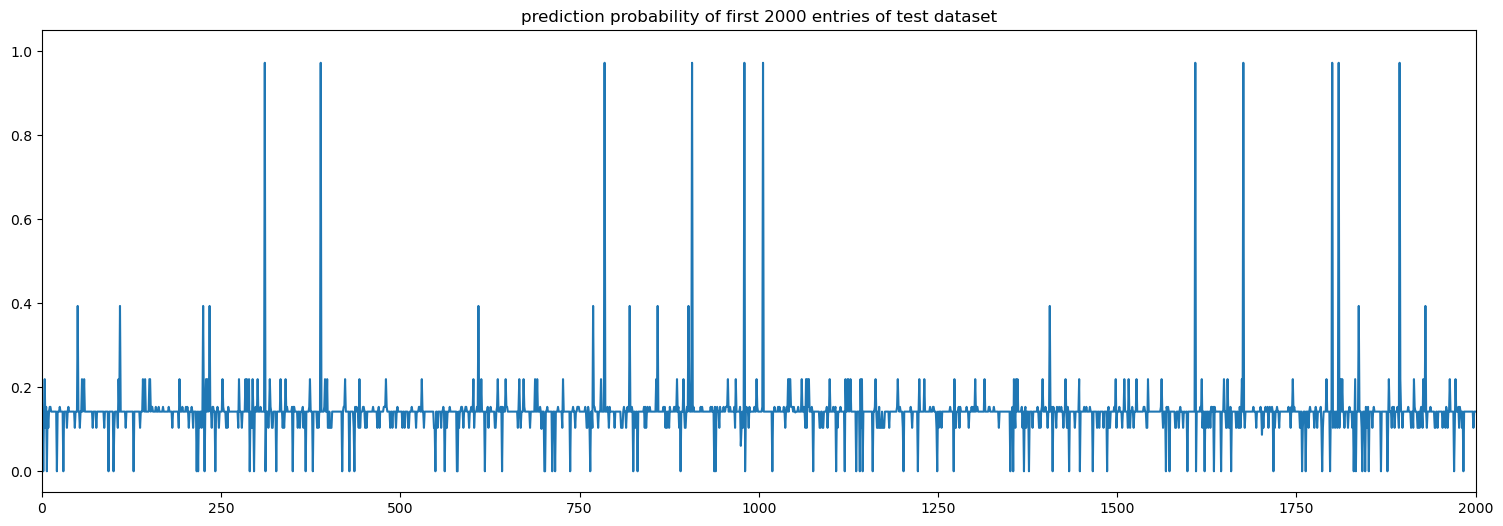

In [88]:
clf = train_classifier('decision_tree', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
# saved directly to working directory
plot_decision_tree(clf, df, filename)

#### MLP

In [89]:
#clf = train_classifier('mlp', X_train, y_train)
#test_accuracy(clf, X_test, y_test, X_train, y_train)
#plot_test_results(clf, X_test, y_test)

#### Comparison Logistic Regression vs. Decision Tree

In [90]:
clf_logreg = LogisticRegression()
clf_logreg.fit(X_train, y_train)
clf_dectree = DecisionTreeClassifier()
clf_dectree.fit(X_train, y_train)

DecisionTreeClassifier()

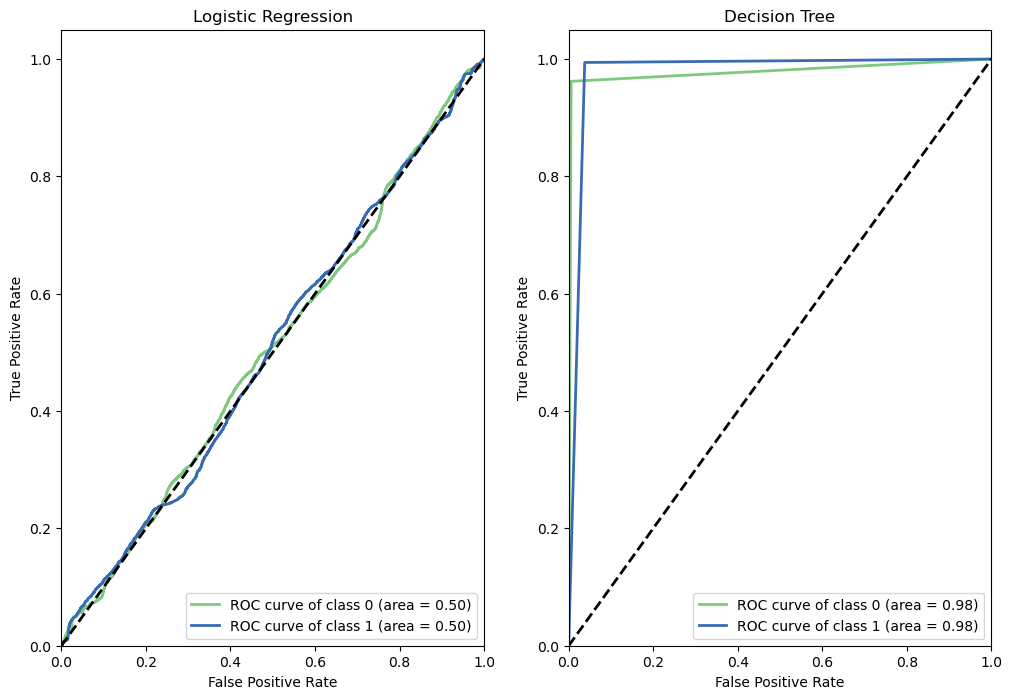

In [91]:
predicted_probas_logreg = clf_logreg.predict_proba(X_test)
predicted_probas_dectree = clf_dectree.predict_proba(X_test)
# y_test = ground truth, predicted_probas = 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('LogisticRegression')
ax2.set_title('DecisionTreeClassifier')
skplt.metrics.plot_roc(y_test, predicted_probas_logreg,ax=ax1, plot_micro=False, plot_macro=False, title = 'Logistic Regression', cmap='Accent',)
skplt.metrics.plot_roc(y_test, predicted_probas_dectree,ax=ax2, plot_micro=False, plot_macro=False, title = 'Decision Tree', cmap='Accent',)
plt.show()

## **4. MZVAV-2-1 Results**

In [2]:
filename = 'MZVAV-2-1'
df, X_raw, y_raw = load_and_process(filename)
df

NameError: name 'load_and_process' is not defined

In [93]:
X_train, X_test, y_train, y_test = split_and_scale(X_raw, y_raw)

#### Logistic Regression

Test accuracy of logistic regression on test dataset: 0.9688888888888889
Test accuracy of logistic regression on train dataset: 0.9651851851851851
[[ 2.83006636e+00  5.73397049e-01  4.85067561e+00  1.05691659e+00
  -5.79651644e-01  5.26903939e+00  7.26185778e+00 -1.73005924e+00
  -2.92818850e+00 -9.58204813e-01 -8.95456521e+00  1.20030915e+01
  -9.35299099e-02  1.05963936e+00  8.79712409e-19  4.41341982e+00
   1.38041708e+00]] [-15.68147134]
Index(['AHU: Supply Air Temperature', 'AHU: Supply Air Temperature Set Point',
       'AHU: Outdoor Air Temperature', 'AHU: Mixed Air Temperature',
       'AHU: Return Air Temperature', 'AHU: Supply Air Fan Status',
       'AHU: Return Air Fan Status',
       'AHU: Supply Air Fan Speed Control Signal',
       'AHU: Return Air Fan Speed Control Signal',
       'AHU: Exhaust Air Damper Control Signal  ',
       'AHU: Outdoor Air Damper Control Signal  ',
       'AHU: Return Air Damper Control Signal',
       'AHU: Cooling Coil Valve Control Signal',


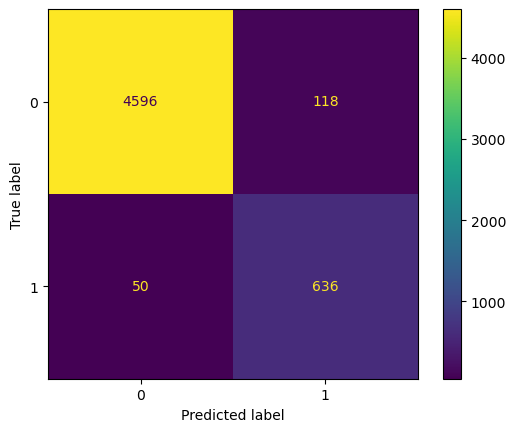

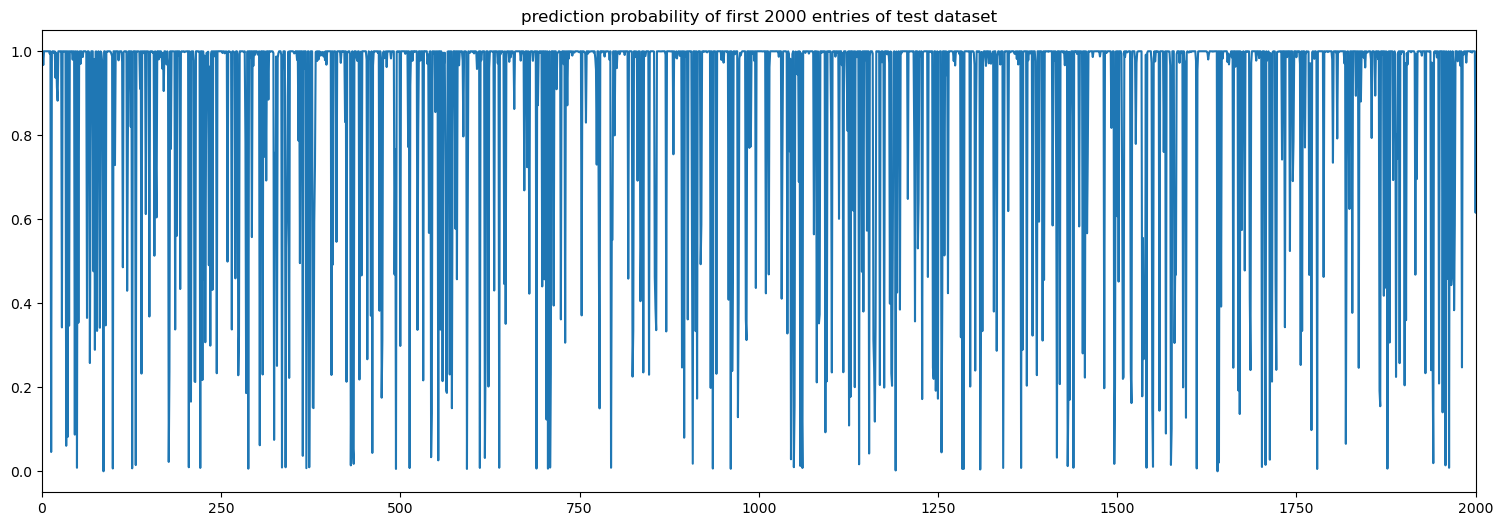

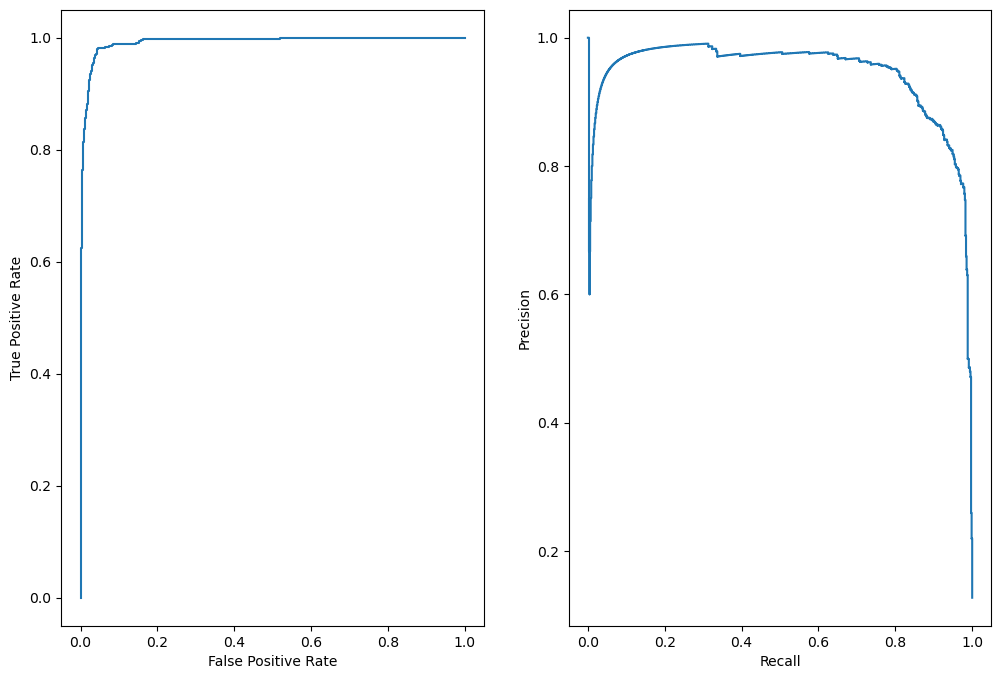

In [94]:
clf = train_classifier('logistic_regression', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
coeff, intercept = coefficients_intercept(df, clf)
plot_rate_precision(clf, X_test, y_test)

#### Decision Tree

Test accuracy of logistic regression on test dataset: 0.9727777777777777
Test accuracy of logistic regression on train dataset: 0.9725308641975309


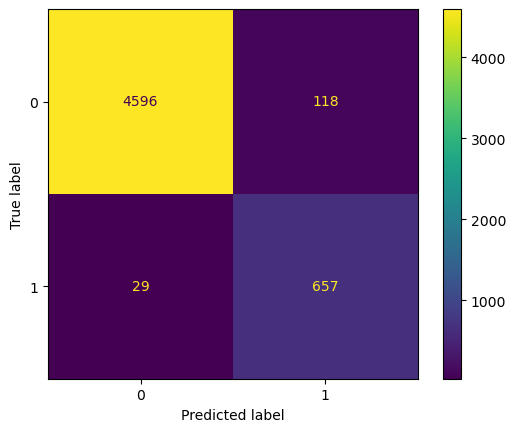

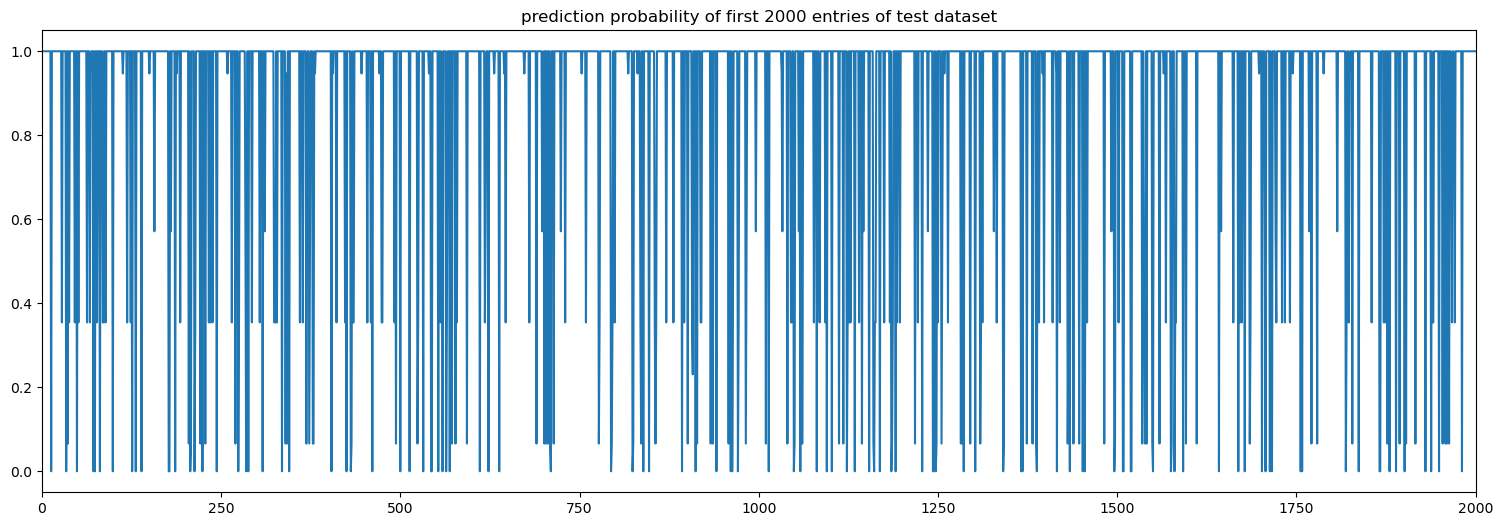

In [95]:
clf = train_classifier('decision_tree', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
# saved directly to working directory
plot_decision_tree(clf, df, filename)

#### MLP

Test accuracy of logistic regression on test dataset: 0.9959259259259259
Test accuracy of logistic regression on train dataset: 0.9961111111111111


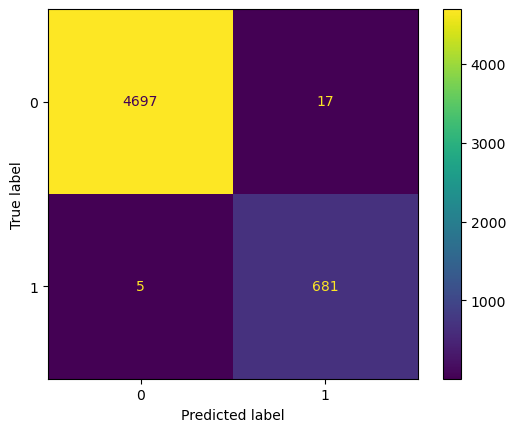

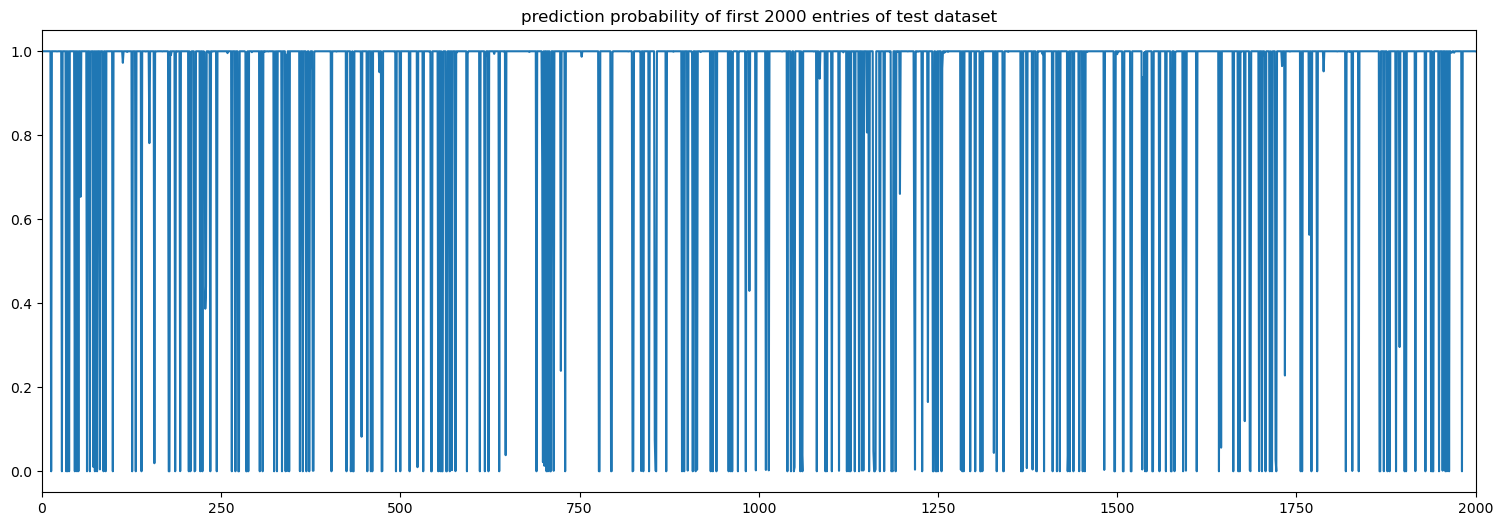

In [96]:
clf = train_classifier('mlp', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)

## **5. MZVAV-2-2 Results**

In [8]:
filename = 'MZVAV-2-2'
df, X_raw, y_raw = load_and_process(filename)
df

The initial df has the shape (37440, 19)
The new df without NaN/wrong values entries has the shape (37440, 19)


,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
0,8/28/2007 0:00,77.13,55,80.61,75.86,75.19,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.06,0,1
1,8/28/2007 0:01,77.63,55,80.68,75.38,75.18,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.17,0,1
2,8/28/2007 0:02,77.87,55,80.66,75.28,75.18,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.34,0,1
3,8/28/2007 0:03,77.95,55,80.69,75.27,75.20,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.57,0,1
4,8/28/2007 0:04,78.59,55,80.60,75.29,75.24,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,1.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37435,5/15/2009 23:55,62.56,55,55.62,55.62,57.88,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.01,0,0
37436,5/15/2009 23:56,62.55,55,55.59,55.59,57.89,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.01,0,0
37437,5/15/2009 23:57,62.54,55,55.50,55.50,57.89,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.01,0,0
37438,5/15/2009 23:58,62.52,55,55.49,55.49,57.88,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.01,0,0


In [9]:
X_train, X_test, y_train, y_test = split_and_scale(X_raw, y_raw)

#### Logistic Regression

Test accuracy of logistic regression on test dataset: 0.881517094017094
Test accuracy of logistic regression on train dataset: 0.8873931623931623
[[ 3.16505904e-01 -1.88804238e+00 -2.42076259e+00  1.17293131e+00
   2.11926540e+00  6.54576798e+00 -6.52787002e+00 -4.38711667e+00
   9.85751600e+00 -7.04965346e-02 -7.04965346e-02  7.04965346e-02
   8.48188579e-01  1.33079712e+00  1.24633604e-16  6.12329273e-01
  -6.52787002e+00]] [1.46016126]
Index(['AHU: Supply Air Temperature', 'AHU: Supply Air Temperature Set Point',
       'AHU: Outdoor Air Temperature', 'AHU: Mixed Air Temperature',
       'AHU: Return Air Temperature', 'AHU: Supply Air Fan Status',
       'AHU: Return Air Fan Status',
       'AHU: Supply Air Fan Speed Control Signal',
       'AHU: Return Air Fan Speed Control Signal',
       'AHU: Exhaust Air Damper Control Signal  ',
       'AHU: Outdoor Air Damper Control Signal  ',
       'AHU: Return Air Damper Control Signal',
       'AHU: Cooling Coil Valve Control Signal',
   

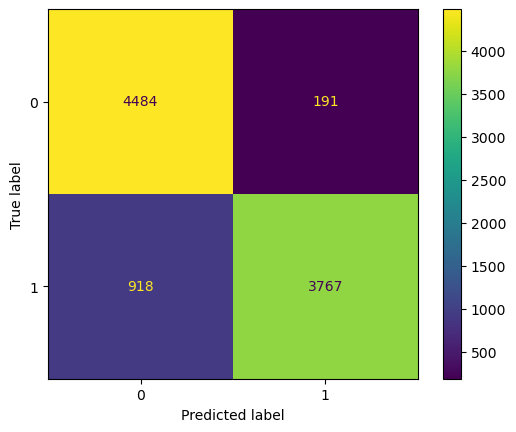

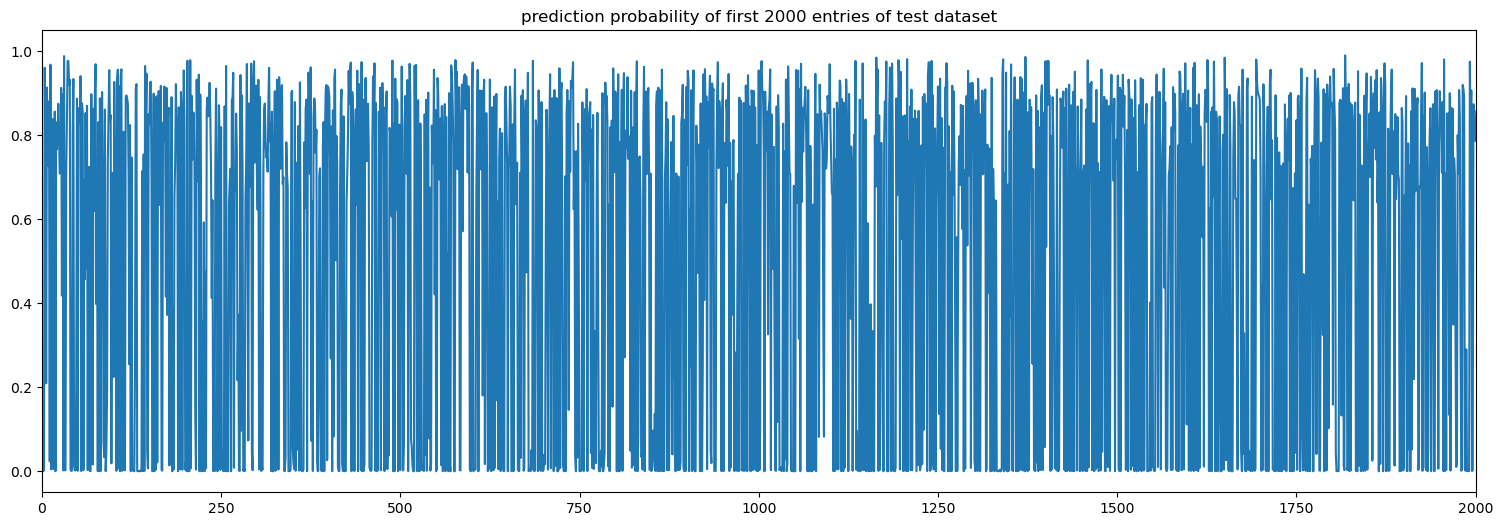

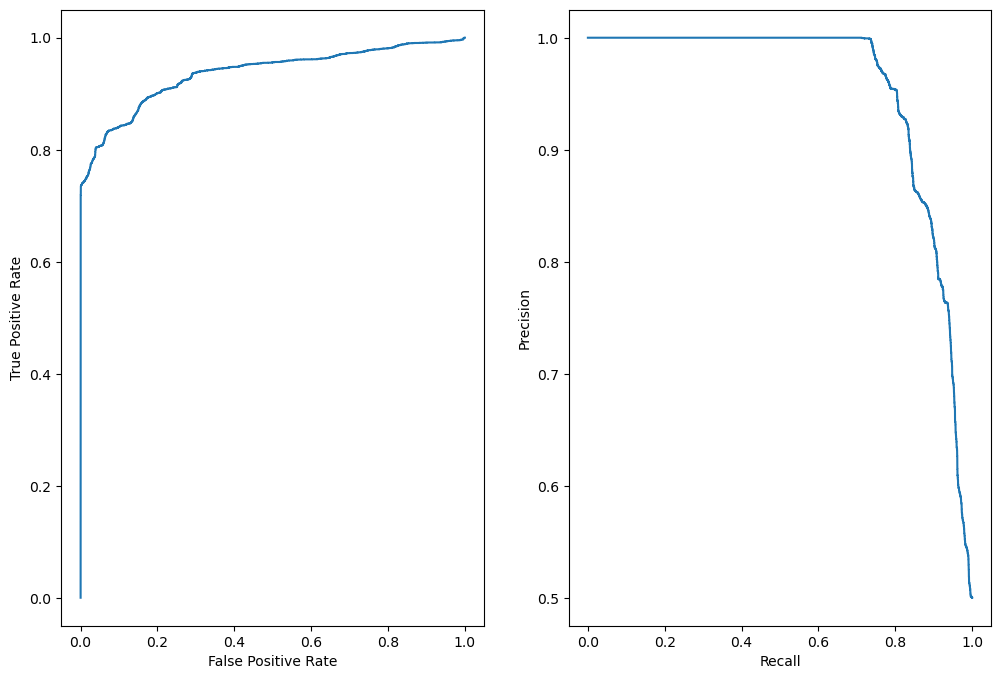

In [11]:
clf = train_classifier('logistic_regression', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
coeff, intercept = coefficients_intercept(df, clf)
plot_rate_precision(clf, X_test, y_test)

#### Decision Tree

Test accuracy of logistic regression on test dataset: 0.9152777777777777
Test accuracy of logistic regression on train dataset: 0.9223290598290599


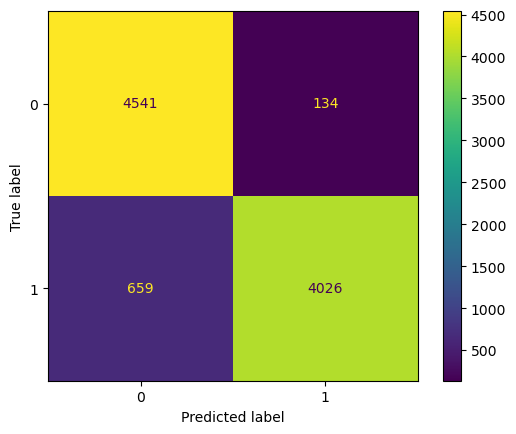

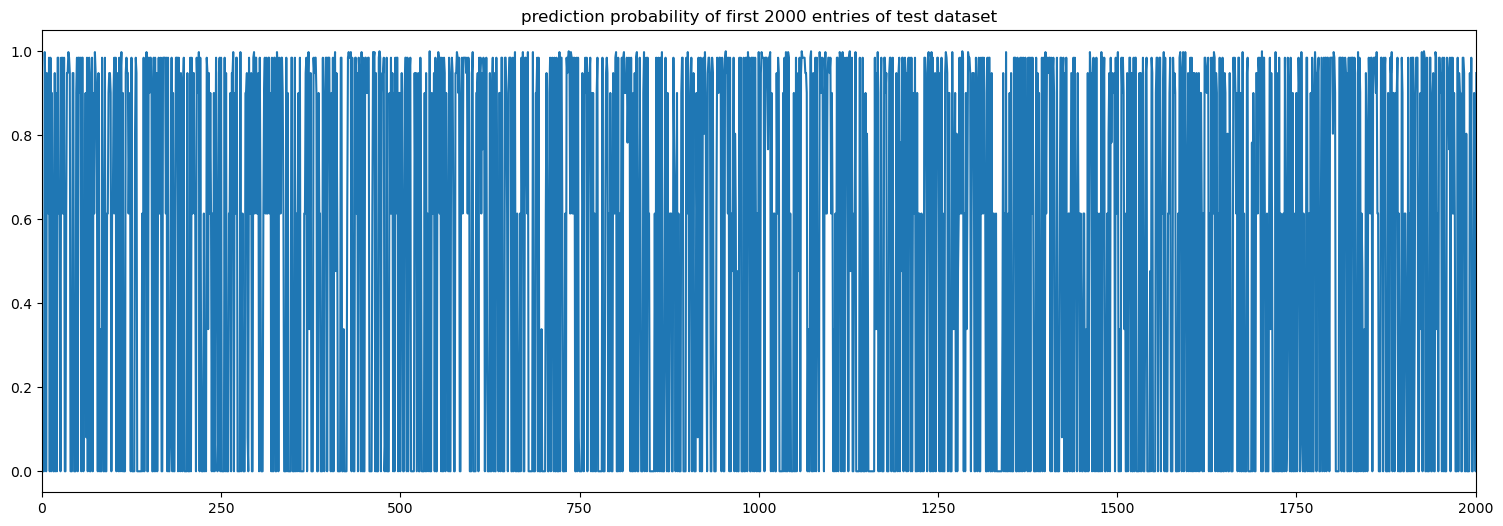

In [12]:
clf = train_classifier('decision_tree', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
# saved directly to working directory
plot_decision_tree(clf, df, filename)

#### MLP

In [101]:
#clf = train_classifier('mlp', X_train, y_train)
#test_accuracy(clf, X_test, y_test, X_train, y_train)
#plot_test_results(clf, X_test, y_test)

## **6. RTU Results**

In [102]:
filename = 'RTU'
df, X_raw, y_raw = load_and_process(filename)
df

The initial df has the shape (30240, 69)
The new df without NaN/wrong values entries has the shape (2867, 69)


,Timestamp,RTU: Supply Air Temperature,RTU: Return Air Temperature,RTU: Supply Air Fan Status,RTU: Circuit 1 Discharge Temperature,RTU: Circuit 1 Condenser Outlet Temperature,RTU: Circuit 1 Suction Temperature,RTU: Circuit 2 Discharge Temperature,RTU: Circuit 2 Condenser Outlet Temperature,RTU: Circuit 2 Suction Temperature,...,VAV Box: Room 103 Air Temperature,VAV Box: Room 104 Air Temperature,VAV Box: Room 105 Air Temperature,VAV Box: Room 106 Air Temperature,VAV Box: Room 202 Air Temperature,VAV Box: Room 203 Air Temperature,VAV Box: Room 204 Air Temperature,VAV Box: Room 205 Air Temperature,VAV Box: Room 206 Air Temperature,Fault Detection Ground Truth
403,8/27/2017 6:43,67.22,74.72,1,92.20,75.87,58.50,75.88,70.95,70.92,...,69.04,69.54,69.52,70.06,69.85,69.22,69.79,69.47,70.09,1
404,8/27/2017 6:44,62.92,74.76,1,119.20,96.10,59.00,73.93,69.79,71.32,...,66.86,67.77,67.92,68.94,67.38,65.89,67.17,66.57,67.71,1
405,8/27/2017 6:45,61.00,74.70,1,133.70,106.30,55.05,73.54,69.30,71.47,...,64.79,65.85,66.06,67.38,65.22,63.40,64.95,64.24,65.58,1
406,8/27/2017 6:46,58.69,74.57,1,144.10,123.90,49.69,117.00,92.00,49.95,...,63.08,64.25,64.39,65.91,63.35,61.47,63.06,62.38,63.79,1
407,8/27/2017 6:47,56.98,74.46,1,157.10,138.30,50.53,160.80,114.70,50.92,...,61.08,62.32,62.54,64.23,61.12,59.18,60.93,60.27,61.78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17154,12/24/2017 21:54,51.34,69.83,1,105.00,63.85,51.18,59.60,50.35,61.47,...,54.23,74.43,77.99,78.23,55.87,67.48,80.40,84.50,83.90,1
17157,12/24/2017 21:57,63.67,69.81,1,90.50,66.44,63.27,64.81,60.84,66.20,...,57.78,77.85,80.30,79.69,62.47,66.09,85.80,90.10,88.70,1
17160,12/24/2017 22:00,53.46,69.91,1,103.70,63.93,34.15,59.76,49.08,60.44,...,57.16,76.36,78.20,79.34,62.99,64.45,81.40,85.10,86.20,1
20586,1/31/2018 7:06,63.82,64.78,1,27.05,21.62,27.45,28.59,29.90,29.86,...,63.29,68.60,72.67,81.70,65.99,93.20,73.25,88.10,75.35,1


In [103]:
X_train, X_test, y_train, y_test = split_and_scale(X_raw, y_raw)

#### Logistic Regression

In [104]:
#clf = train_classifier('logistic_regression', X_train, y_train)
#test_accuracy(clf, X_test, y_test, X_train, y_train)
#plot_test_results(clf, X_test, y_test)
#coeff, intercept = coefficients_intercept(df, clf)
#plot_rate_precision(clf, X_test, y_test)

#### Decision Tree

Test accuracy of logistic regression on test dataset: 1.0
Test accuracy of logistic regression on train dataset: 1.0


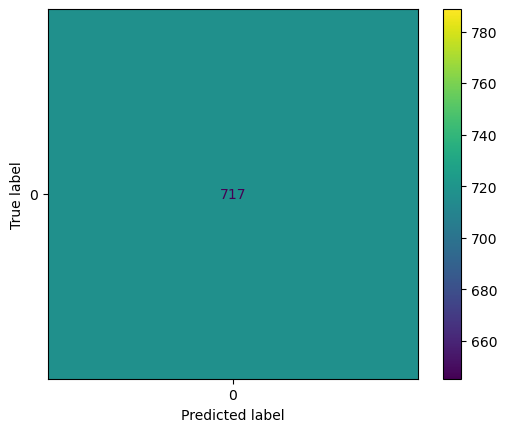

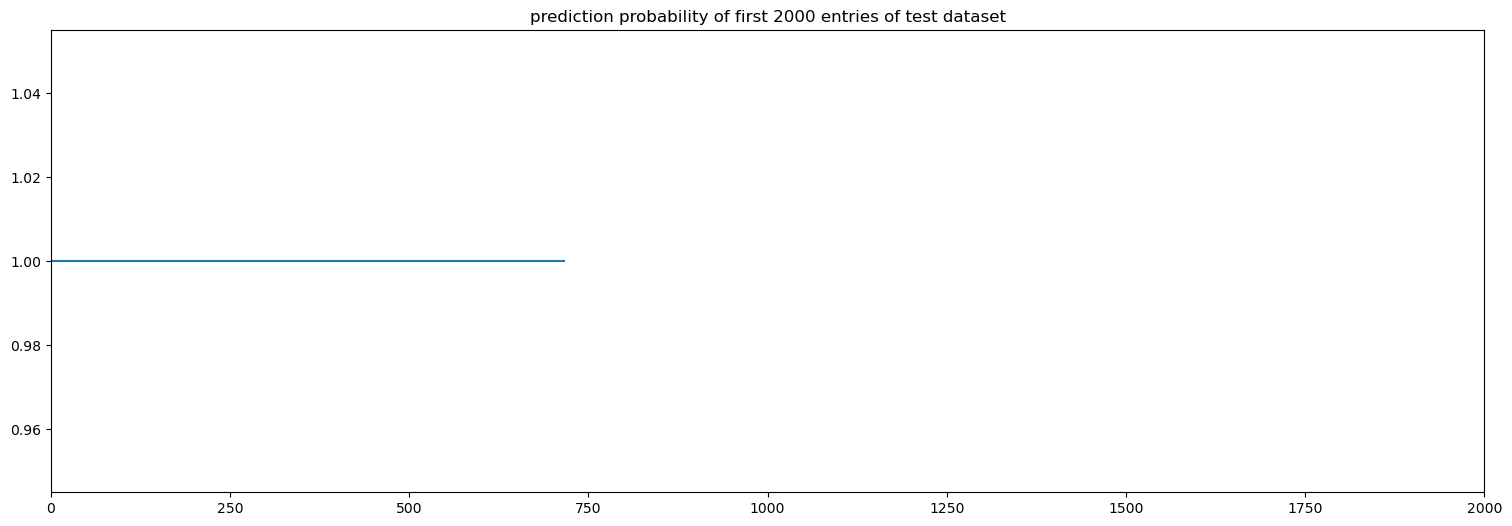

In [105]:
clf = train_classifier('decision_tree', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
# saved directly to working directory
plot_decision_tree(clf, df, filename)

## **7. SZCAV Results**

In [106]:
filename = 'SZCAV'
df, X_raw, y_raw = load_and_process(filename)
df

The initial df has the shape (21600, 16)
The new df without NaN/wrong values entries has the shape (21510, 16)


,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
0,3/11/2017 0:00,72.99,50.0,86.0,62.57,72.11,72.36,1,0.5,0.0,1.0,0.0,0.0,0.0,0,1
1,3/11/2017 0:01,72.98,50.0,86.0,62.57,72.11,72.36,1,0.5,0.0,1.0,0.0,0.0,0.0,0,1
2,3/11/2017 0:02,72.99,50.0,86.0,62.57,72.11,72.36,1,0.5,0.0,1.0,0.0,0.0,0.0,0,1
3,3/11/2017 0:03,72.97,50.0,86.0,62.57,72.1,72.35,1,0.5,0.0,1.0,0.0,0.0,0.0,0,1
4,3/11/2017 0:04,72.97,50.0,86.0,62.57,72.1,72.35,1,0.5,0.0,1.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,4/1/2017 23:55,71.95,50.0,86.0,50.63,71.24,71.43,1,0.5,0.0,1.0,0.0,0.0,0.0,0,0
21596,4/1/2017 23:56,71.95,50.0,86.0,50.63,71.24,71.41,1,0.5,0.0,1.0,0.0,0.0,0.0,0,0
21597,4/1/2017 23:57,71.93,50.0,86.0,50.63,71.25,71.41,1,0.5,0.0,1.0,0.0,0.0,0.0,0,0
21598,4/1/2017 23:58,71.93,50.0,86.0,50.63,71.23,71.40,1,0.5,0.0,1.0,0.0,0.0,0.0,0,0


In [107]:
X_train, X_test, y_train, y_test = split_and_scale(X_raw, y_raw)

#### Logistic Regression

Test accuracy of logistic regression on test dataset: 0.9550018594272964
Test accuracy of logistic regression on train dataset: 0.9592734936771634
[[-4.26328749 -1.33827284  0.34308969 -1.95245288 -4.27019004  6.11063907
  -0.06758733 -0.10050847 -0.36028338  1.09895314 -1.0969385   1.25612488
   2.65796189  0.07033141]] [6.25879947]
Index(['AHU: Supply Air Temperature',
       'AHU: Supply Air Temperature Heating Set Point',
       'AHU: Supply Air Temperature Cooling Set Point',
       'AHU: Outdoor Air Temperature', 'AHU: Mixed Air Temperature',
       'AHU: Return Air Temperature', 'AHU: Supply Air Fan Status',
       'AHU: Supply Air Fan Speed Control Signal',
       'AHU: Outdoor Air Damper Control Signal  ',
       'AHU: Return Air Damper Control Signal',
       'AHU: Exhaust Air Damper Control Signal    ',
       'AHU: Cooling Coil Valve Control Signal',
       'AHU: Heating Coil Valve Control Signal', 'Occupancy Mode Indicator'],
      dtype='object')


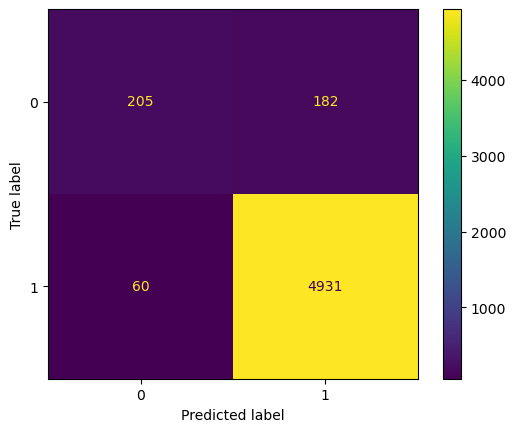

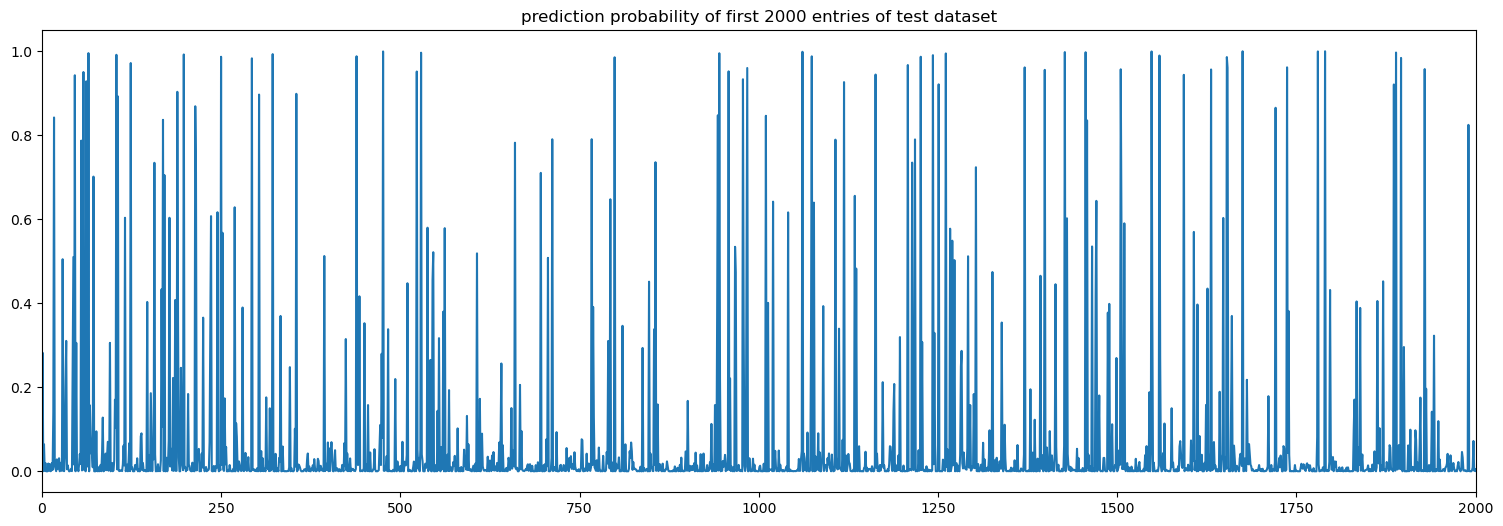

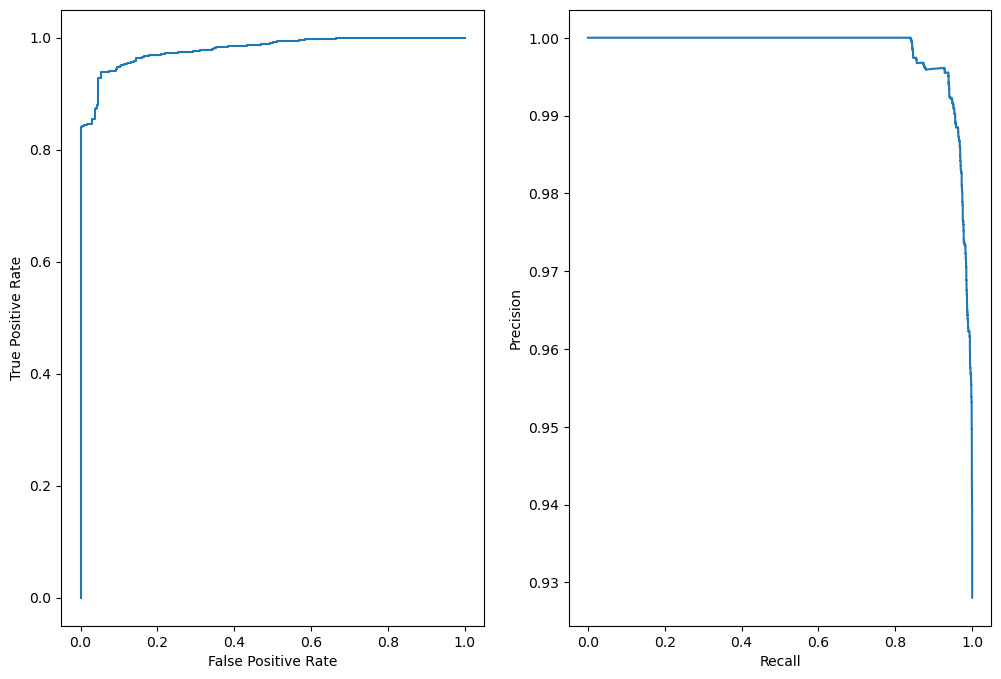

In [108]:
clf = train_classifier('logistic_regression', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
coeff, intercept = coefficients_intercept(df, clf)
plot_rate_precision(clf, X_test, y_test)

#### Decision Tree

Test accuracy of logistic regression on test dataset: 0.9745258460394198
Test accuracy of logistic regression on train dataset: 0.9795437639474337


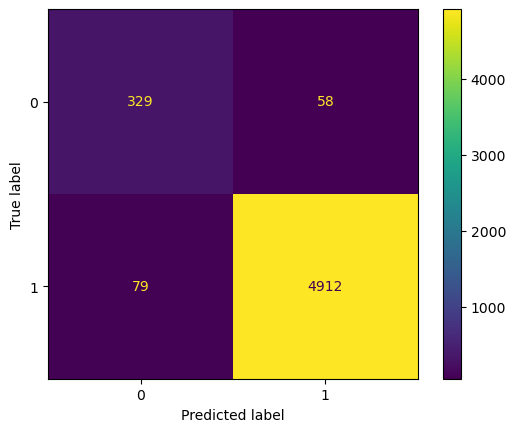

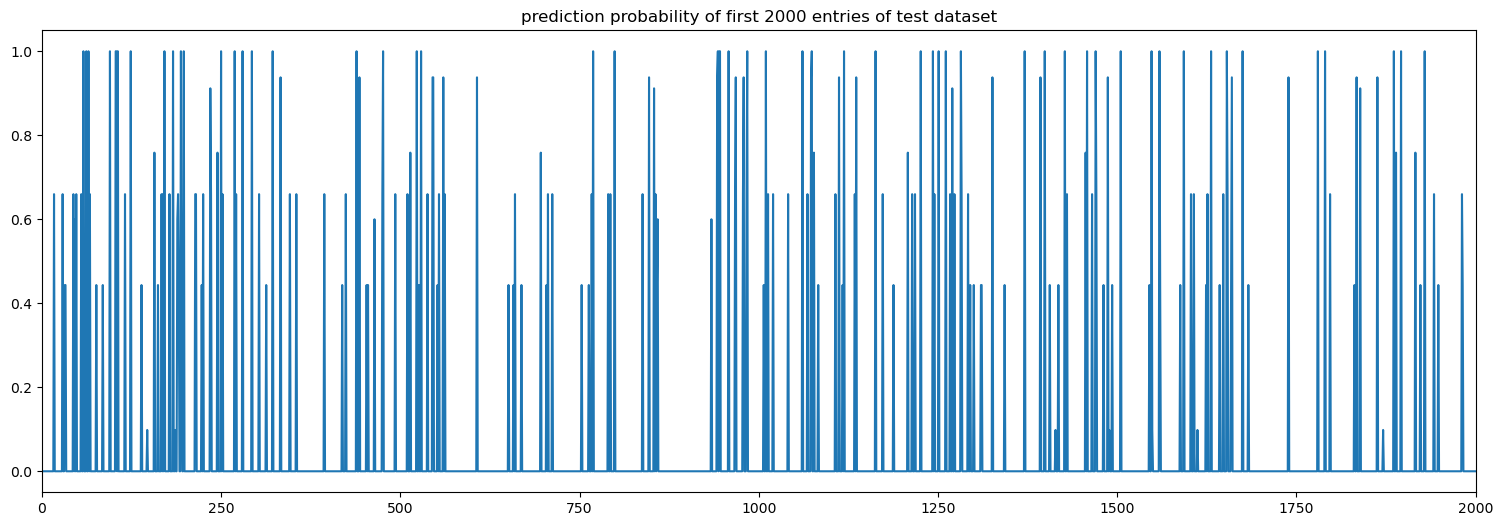

In [109]:
clf = train_classifier('decision_tree', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
# saved directly to working directory
plot_decision_tree(clf, df, filename)

## **8. SZVAV Results**

In [110]:
filename = 'SZVAV'
df, X_raw, y_raw = load_and_process(filename)
df

The initial df has the shape (15839, 16)
The new df without NaN/wrong values entries has the shape (15248, 16)


,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
590,9/11/2017 9:50,58.28,54.86,72.5,75.58,75.42,71.64,1,0.10,0.15,1.00,0.10,0.0,0.0,1,1
591,9/11/2017 9:51,58.31,54.78,72.5,75.49,75.39,72.02,1,0.10,0.15,1.00,0.10,0.0,0.0,1,1
592,9/11/2017 9:52,58.31,54.08,72.5,75.55,75.57,72.62,1,0.10,0.15,1.00,0.10,0.0,0.0,1,1
593,9/11/2017 9:53,58.29,53.41,72.5,75.71,75.88,73.20,1,0.10,0.15,1.00,0.10,0.0,0.0,1,1
594,9/11/2017 9:54,58.18,53.04,72.5,75.75,76.27,73.82,1,0.11,0.15,1.00,0.10,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15834,9/24/2017 23:54,71.59,72.50,72.5,65.05,74.65,73.42,1,0.10,0.11,0.89,0.07,0.0,0.0,0,0
15835,9/24/2017 23:55,71.58,72.50,72.5,65,74.63,73.42,1,0.10,0.11,0.89,0.06,0.0,0.0,0,0
15836,9/24/2017 23:56,71.58,72.50,72.5,64.93,74.59,73.43,1,0.10,0.11,0.89,0.06,0.0,0.0,0,0
15837,9/24/2017 23:57,71.57,72.50,72.5,64.85,74.59,73.41,1,0.10,0.11,0.89,0.06,0.0,0.0,0,0


In [111]:
X_train, X_test, y_train, y_test = split_and_scale(X_raw, y_raw)

#### Logistic Regression

Test accuracy of logistic regression on test dataset: 0.7479013641133263
Test accuracy of logistic regression on train dataset: 0.7493878978663868
[[-0.25874786 -1.59489539  0.93378174  0.19366548  0.31252639  2.69223539
   0.         -0.15431311  2.49397036  7.63729545  5.69632244  2.7132987
   0.986096   -1.72238129]] [2.62778575]
Index(['AHU: Supply Air Temperature',
       'AHU: Supply Air Temperature Heating Set Point',
       'AHU: Supply Air Temperature Cooling Set Point',
       'AHU: Outdoor Air Temperature', 'AHU: Mixed Air Temperature',
       'AHU: Return Air Temperature', 'AHU: Supply Air Fan Status',
       'AHU: Supply Air Fan Speed Control Signal',
       'AHU: Outdoor Air Damper Control Signal  ',
       'AHU: Return Air Damper Control Signal',
       'AHU: Exhaust Air Damper Control Signal    ',
       'AHU: Cooling Coil Valve Control Signal',
       'AHU: Heating Coil Valve Control Signal', 'Occupancy Mode Indicator'],
      dtype='object')


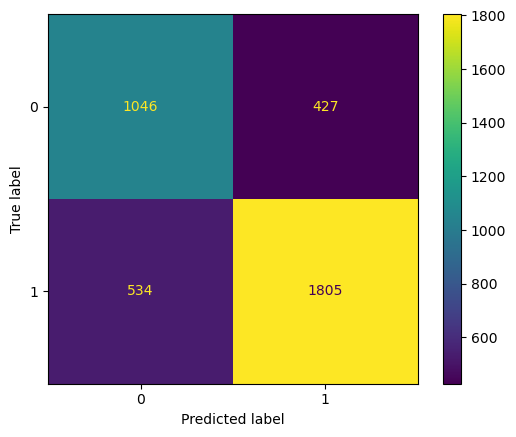

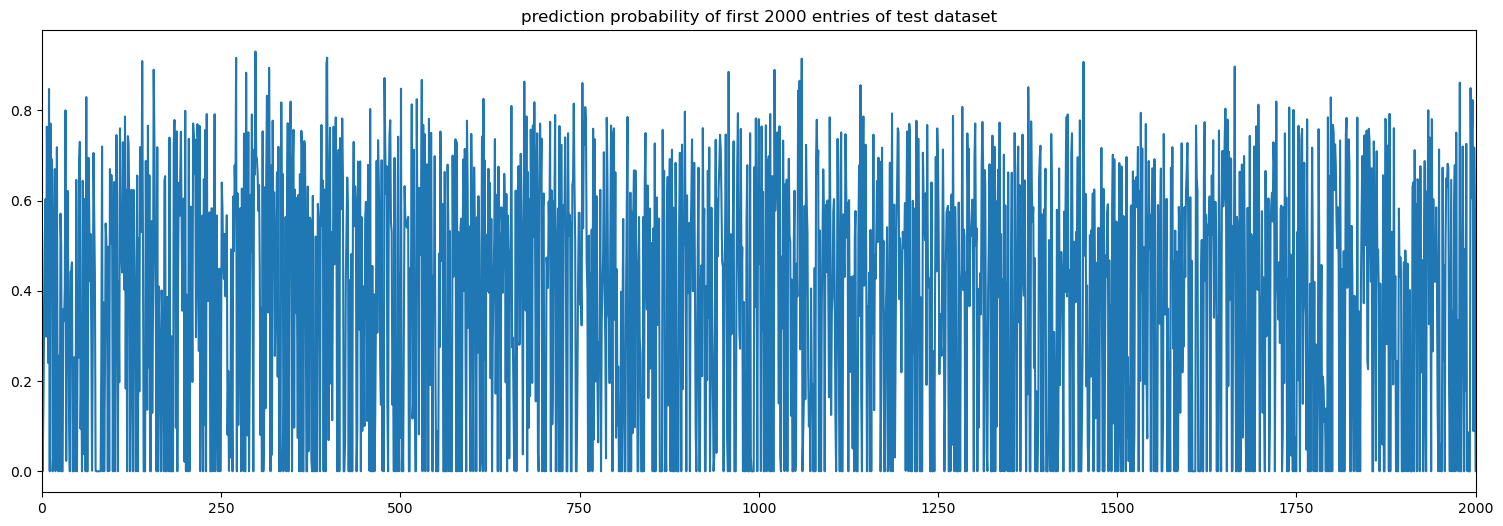

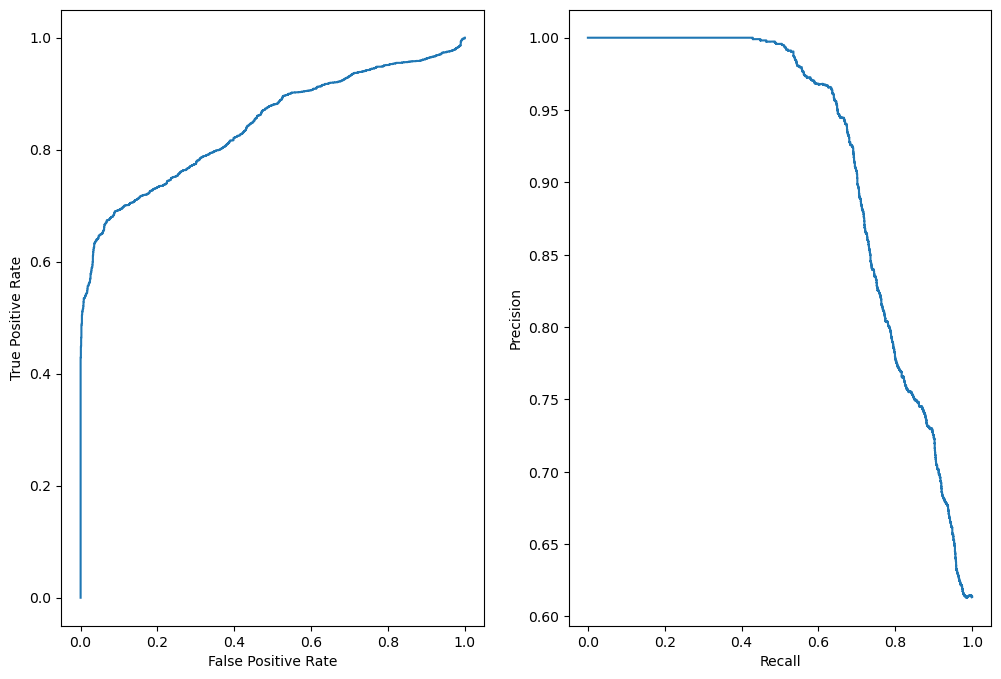

In [112]:
clf = train_classifier('logistic_regression', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
coeff, intercept = coefficients_intercept(df, clf)
plot_rate_precision(clf, X_test, y_test)

#### Decision Tree

Test accuracy of logistic regression on test dataset: 0.8502098635886673
Test accuracy of logistic regression on train dataset: 0.8452256033578174


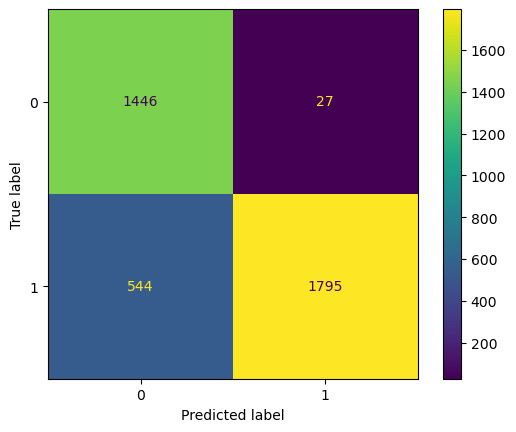

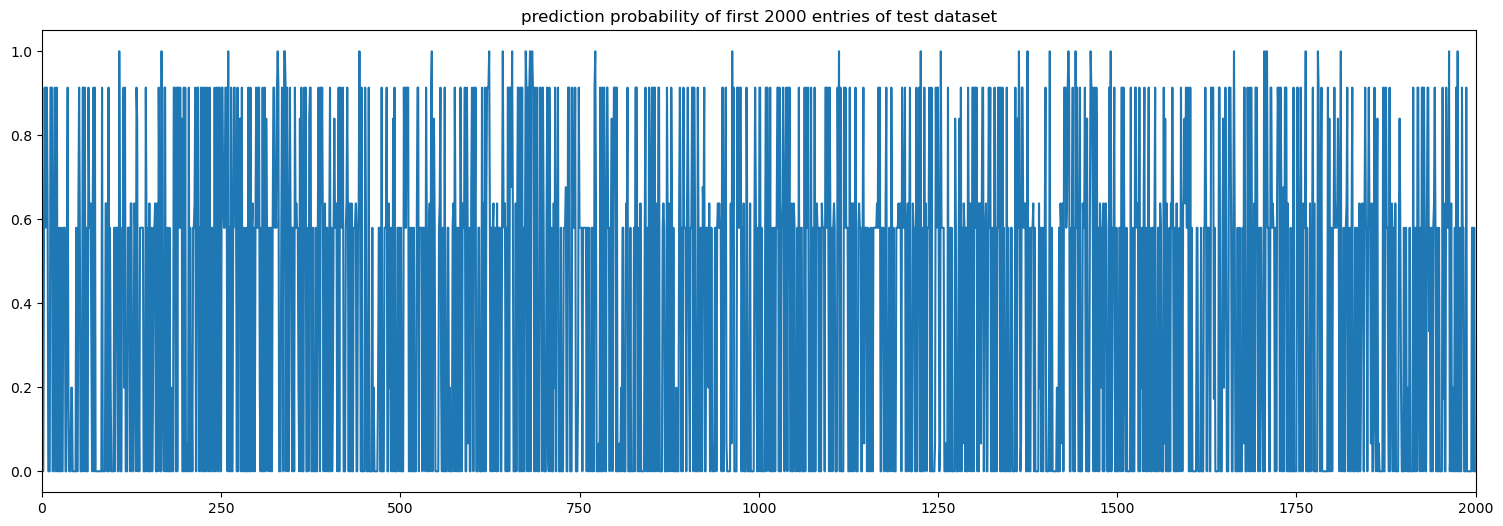

In [113]:
clf = train_classifier('decision_tree', X_train, y_train)
test_accuracy(clf, X_test, y_test, X_train, y_train)
plot_test_results(clf, X_test, y_test)
# saved directly to working directory
plot_decision_tree(clf, df, filename)